**Archive Link:**   <https://drive.google.com/file/d/1umHdeGY3KKu2zjh8VxmJGtirPNgOmpVw/view?usp=sharing> 

## Project Description:

The virtual telephony service CallMeMaybe is developing a new function that will give supervisors information on the least effective operators. An operator is considered ineffective if they have a large number of missed incoming calls (internal and external) and a long waiting time for incoming calls. Moreover, if an operator is supposed to make outgoing calls, a small number of them is also a sign of ineffectiveness.

### Project Decomposition:

[**1. Data Pre_processing:**](#Data-Pre_processing:)  

    - Checking Data Types
    - Missing Values
    - Duplicates
    
[**2. Carry out exploratory data analysis:**](#Carry-out-exploratory-data-analysis:)

    - Check the data for strange values
    - Calculate and make new column `waiting_time`
    - Check the dates 
    - plot histograms for `call_duration`, `total_call_duration` , `calls_count` and `waiting_time`
    - Check for outliers
    
[**3. Identify ineffective operators:**](#Identify-ineffective-operators:)

    - find average daily waiting time per operator (for incoming calls)
    - find average daily missed calls per operator (for incoming calls)
    - find average daily number of calls per operator (in + out)
    - find average percentage of daily outgoing calls per operator 
    - Scatter between missed calls and waiting time per operator
    - compare internal and external number of calls per operator
    - Compare the previous metrrics (steps) and identify the ineffective operators based on their results
    
    
[**4. Test statistical hypotheses**](#Test-statistical-hypotheses:) 

    - share of external / internal calls is the same for effective and ineffective operators   
    - share of outgoing / incoming calls are the same for effective and ineffective operators 
    
[**5. Final Conclusions**](#Final-Conclusions:)


### Description of the data
- `user_id` — client account ID
- `date` — date the statistics were retrieved
- `direction` — call direction (`out` for outgoing, `in` for incoming)
- `internal` — whether the call was internal (between a client's operators)
- `operator_id` — operator identifier
- `is_missed_call` — whether the call was missed
- `calls_count` — number of calls
- `call_duration` — call duration (excluding waiting time)
- `total_call_duration` — call duration (including waiting time)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import levene

## Data Pre_processing:

In [3]:
data = pd.read_csv('/datasets/telecom_dataset_us.csv')
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


### Datatypes

In [5]:
data.isna().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

we see that we have 117 Missing value in `internal` and wi th no way to fill them we will drop them because when we'll change the data type of this column to bool the values will autmatically be changed to one of the Types 

In [6]:
data = data.dropna(subset=['internal'])

In [7]:
data.isna().sum()

user_id                   0
date                      0
direction                 0
internal                  0
operator_id            8115
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [8]:
# changing data type
data['date'] = pd.to_datetime(data['date'])
data['internal'] = data['internal'].astype('bool')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53785 non-null  int64                                
 1   date                 53785 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53785 non-null  object                               
 3   internal             53785 non-null  bool                                 
 4   operator_id          45670 non-null  float64                              
 5   is_missed_call       53785 non-null  bool                                 
 6   calls_count          53785 non-null  int64                                
 7   call_duration        53785 non-null  int64                                
 8   total_call_duration  53785 non-null  int64                                
dtypes: bool

In [9]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [10]:
#get rid of the timezone to make calculations easier (Documentaion in the end)
data['date'] = data['date'].dt.tz_localize(None)
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25


### Missing values + Duplicates:

In [11]:
original_len = len(data)

In [12]:
data[data['operator_id'].isna()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
7,166377,2019-08-05,in,False,NaN,True,6,0,35
9,166377,2019-08-06,in,False,NaN,True,4,0,62
17,166377,2019-08-07,in,False,NaN,True,2,0,24
27,166377,2019-08-12,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27,in,False,NaN,True,2,0,39
53880,168601,2019-11-28,in,False,NaN,True,1,0,19
53889,168603,2019-11-28,in,False,NaN,True,1,0,30
53893,168606,2019-11-08,in,False,NaN,True,6,0,121


In [13]:
print('number of NAN:',data['operator_id'].isna().sum())

number of NAN: 8115


In [14]:
print('percent of NAN:', '{0:.2%}'.format(data['operator_id'].isna().sum() / len(data)))

percent of NAN: 15.09%


- The missing values are all in `operator_id` which is one of the m,ost important columns and we have no way of filling the missing values or predict them as that can affect the calculations so even if they make 15% of the data we will have to get rid of them.

In [15]:
data.duplicated().sum()

4893

In [16]:
print('percent of duplicates:', '{0:.2%}'.format(data.duplicated().sum() / len(data)))

percent of duplicates: 9.10%


- Duplicates make 9% of the data but we have to drop them or they will affect the calculations

In [17]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48892 non-null  int64         
 1   date                 48892 non-null  datetime64[ns]
 2   direction            48892 non-null  object        
 3   internal             48892 non-null  bool          
 4   operator_id          41491 non-null  float64       
 5   is_missed_call       48892 non-null  bool          
 6   calls_count          48892 non-null  int64         
 7   call_duration        48892 non-null  int64         
 8   total_call_duration  48892 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 3.1+ MB


In [18]:
# checking for missing values again after dropping the duplicates and see if their number still the smae or decreased
print('number of NAN:',data['operator_id'].isna().sum())

number of NAN: 7401


In [19]:
print('percent of NAN:', '{0:.2%}'.format(data['operator_id'].isna().sum() / len(data)))

percent of NAN: 15.14%


- the number of the missing values decreased abut the percentage still the same. we will drop them because we have no better option

In [20]:
data_clean = data.dropna().copy()
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41491 entries, 1 to 53899
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41491 non-null  int64         
 1   date                 41491 non-null  datetime64[ns]
 2   direction            41491 non-null  object        
 3   internal             41491 non-null  bool          
 4   operator_id          41491 non-null  float64       
 5   is_missed_call       41491 non-null  bool          
 6   calls_count          41491 non-null  int64         
 7   call_duration        41491 non-null  int64         
 8   total_call_duration  41491 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.6+ MB


In [21]:
print('percent of data left:', '{0:.2%}'.format(len(data_clean) / original_len))

percent of data left: 77.14%


- After proccessing the missing values and duplicates we still have 77% of our original data left

## Carry out exploratory data analysis:

### Check Values:

In [22]:
data_clean['direction'].value_counts()

out    28813
in     12678
Name: direction, dtype: int64

In [23]:
data_clean['internal'].value_counts()

False    36161
True      5330
Name: internal, dtype: int64

In [24]:
data_clean['is_missed_call'].value_counts()

False    27382
True     14109
Name: is_missed_call, dtype: int64

In [25]:
data_clean['operator_id'].nunique()

1092

- the values are not distributed equally in the above columnns but they have no strange values
- we have 1092 Operator included in the data

### Calculate Waiting Time

In [26]:
data_clean['waiting_time'] = data_clean['total_call_duration'] - data_clean['call_duration']
#data_clean['waiting_time'].where(data_clean['direction'] == 'in', np.nan, inplace=True)
data_clean.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,26


### Check the Dates

In [27]:
data_clean['waiting_time'].describe()

count    41491.000000
mean       312.213227
std       1176.102940
min          0.000000
25%         19.000000
50%         60.000000
75%        219.000000
max      46474.000000
Name: waiting_time, dtype: float64

In [28]:
data_clean['date'].describe(datetime_is_numeric=True)

count                            41491
mean     2019-10-23 15:58:20.739919616
min                2019-08-02 00:00:00
25%                2019-10-06 00:00:00
50%                2019-10-28 00:00:00
75%                2019-11-14 00:00:00
max                2019-11-28 00:00:00
Name: date, dtype: object

- Data are spread on 4 months starting 2nd of august till 28th of november 2019
- 50% of our data are in the first 3 months and the other 50% are in the last month
- the bad distribution we not affect the studies greatly as we will calculate the daily average so how the data is spread will not matter

### Plot Histograms + Outliers:

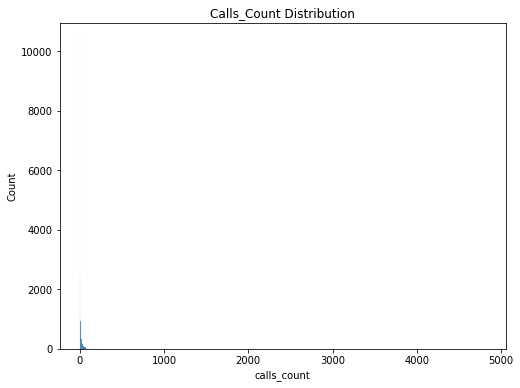

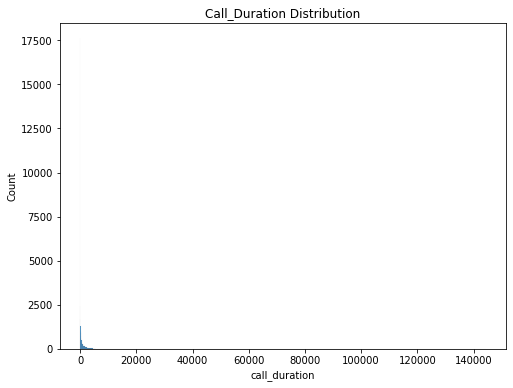

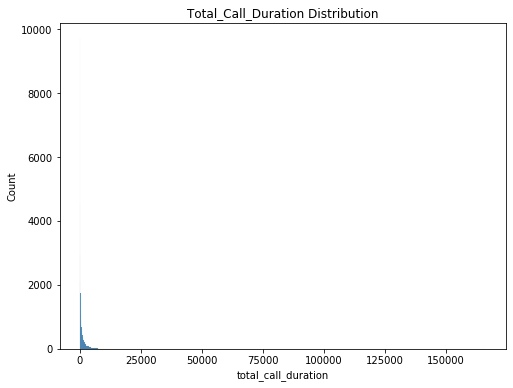

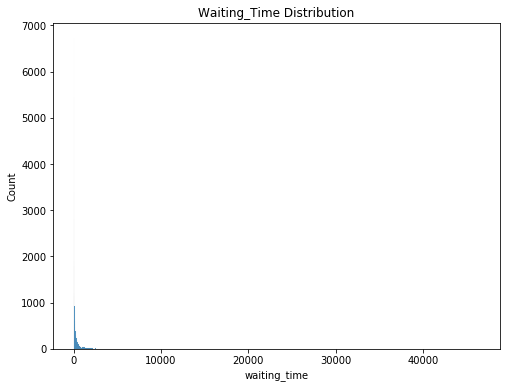

In [29]:
for i in ['calls_count', 'call_duration', 'total_call_duration', 'waiting_time']:
    plt.figure(figsize = (8,6))
    sns.histplot(data = data_clean, x=i )
    plt.title(f'{i.title()} Distribution');
    plt.show()

In [30]:
data_clean[['calls_count', 'call_duration', 'total_call_duration', 'waiting_time']].describe()

,calls_count,call_duration,total_call_duration,waiting_time
count,41491.000000,41491.000000,41491.000000,41491.000000
mean,16.921381,1010.940011,1323.153238,312.213227
std,59.786187,4066.666485,4788.953155,1176.102940
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,67.000000,19.000000
50%,4.000000,106.000000,289.000000,60.000000
75%,14.000000,772.000000,1107.000000,219.000000
max,4817.000000,144395.000000,166155.000000,46474.000000


- From the Hists and describe Table we see that we have huge outliers that will affect the analysis greatly so we will get rid of them.

In [31]:
# checking the percentile for the columns with outliers to try and point the limit 
for i in ['calls_count', 'call_duration', 'total_call_duration', 'waiting_time']:
    print(i, np.percentile(data_clean[i], [90, 95, 96, 97, 98, 99, 99.5, 99.9]))

calls_count [ 37.    65.    74.    87.   107.   165.1  357.65 748.61]
call_duration [ 2407.    4161.5   4914.2   5893.3   7647.   10988.3  16101.25 61652.75]
total_call_duration [ 2935.    5035.5   5988.    7268.4   9499.2  13654.1  19807.3  71631.59]
waiting_time [  659.   1234.5  1434.   1706.   2137.2  3495.4  8055.6 16847. ]


- We will consider for the outliers as the values bigger than the 90th percentile so we will drop them

In [32]:
for i in ['calls_count', 'call_duration', 'total_call_duration', 'waiting_time']:
    limit = np.percentile(data_clean[i], 90)
    data_clean = data_clean[data_clean[i] < limit]

In [33]:
data_clean[['calls_count', 'call_duration', 'total_call_duration', 'waiting_time']].describe()

,calls_count,call_duration,total_call_duration,waiting_time
count,27124.000000,27124.000000,27124.000000,27124.000000
mean,3.202994,166.059615,212.712247,46.652632
std,3.027899,231.356660,245.784319,49.381082
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,37.000000,12.000000
50%,2.000000,50.000000,110.000000,28.000000
75%,4.000000,256.000000,301.000000,63.000000
max,33.000000,1012.000000,1021.000000,225.000000


- From the describe Table we see that the data are still not distributed normaly and there are still values that can be considered outliers but dropping more than that will reduce the data greatly and the study will be biased and affected

In [34]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27124 entries, 1 to 53898
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              27124 non-null  int64         
 1   date                 27124 non-null  datetime64[ns]
 2   direction            27124 non-null  object        
 3   internal             27124 non-null  bool          
 4   operator_id          27124 non-null  float64       
 5   is_missed_call       27124 non-null  bool          
 6   calls_count          27124 non-null  int64         
 7   call_duration        27124 non-null  int64         
 8   total_call_duration  27124 non-null  int64         
 9   waiting_time         27124 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 1.9+ MB


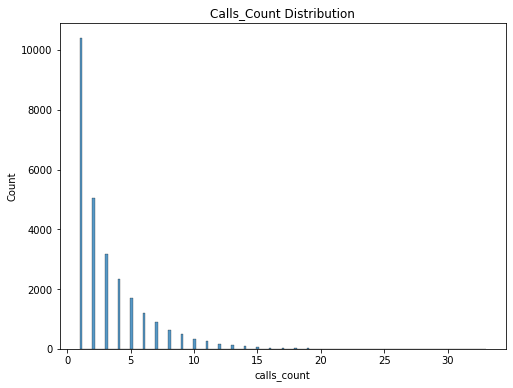

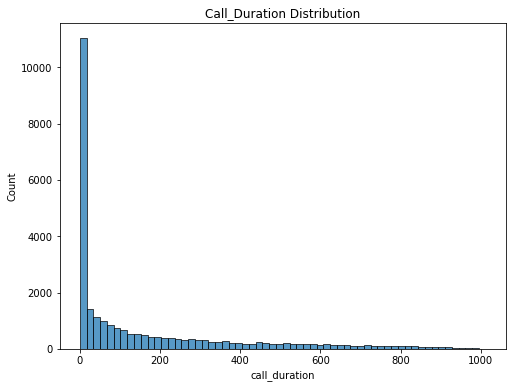

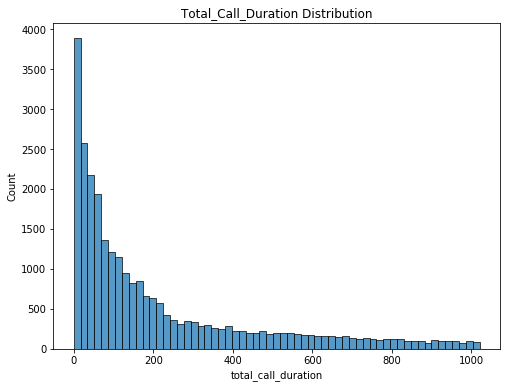

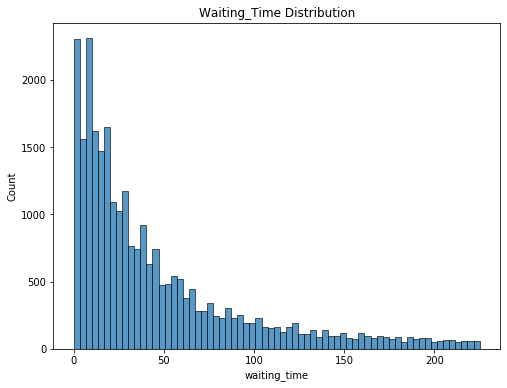

In [35]:
for i in ['calls_count', 'call_duration', 'total_call_duration', 'waiting_time']:
    plt.figure(figsize = (8,6));
    sns.histplot(data = data_clean, x=i );
    plt.title(f'{i.title()} Distribution');
    plt.show();

In [36]:
print('percent of data left:', '{0:.2%}'.format(len(data_clean) / original_len))

percent of data left: 50.43%


- After dropping the outliers the Hists look better and more natural and readable
- After cleaning the data from NaN, Duplicates and outliers we still have 50% of the original data availabe and valid for the analysis.

## Identify ineffective operators:

In [37]:
#number of operators 
data_clean['operator_id'].nunique()

1060

- lets split the data into incoming and outgoind calls

In [38]:
incoming = data_clean[data_clean['direction'] == 'in']
incoming.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
26,166377,2019-08-12,in,False,880028.0,False,1,407,411,4
34,166377,2019-08-13,in,False,880028.0,False,1,88,102,14
37,166377,2019-08-14,in,False,880026.0,False,2,197,218,21
39,166377,2019-08-14,in,False,880028.0,False,1,33,37,4
49,166377,2019-08-15,in,False,880028.0,False,1,23,27,4


In [39]:
#numbers of operators who had incoming calls
incoming['operator_id'].nunique(dropna=True)

752

In [40]:
outgoing = data_clean[data_clean['direction'] == 'out']
outgoing.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,26


In [41]:
#numbers of operators who had outgoing calls
outgoing['operator_id'].nunique(dropna=True)

846

### Find average daily waiting time per operator (for incoming calls)

In [42]:
# sum the waiting time for every operator per date
waiting_operator_date = incoming.groupby(['operator_id', 'date'])['waiting_time'].sum().reset_index()
waiting_operator_date.head()

,operator_id,date,waiting_time
0,879896.0,2019-08-03,9
1,879896.0,2019-08-05,10
2,879896.0,2019-08-06,39
3,879896.0,2019-08-08,6
4,879896.0,2019-08-09,5


In [43]:
# find the daily average waiting time for every operator
avg_waiting_operator = waiting_operator_date.groupby('operator_id')['waiting_time'].mean().reset_index()
avg_waiting_operator.head()

,operator_id,waiting_time
0,879896.0,28.450000
1,879898.0,20.666667
2,880020.0,7.714286
3,880022.0,14.000000
4,880026.0,7.944444


In [44]:
avg_waiting_operator['waiting_time'].describe()

count    752.000000
mean      35.836223
std       26.773715
min        1.000000
25%       17.000000
50%       29.738636
75%       48.000000
max      180.000000
Name: waiting_time, dtype: float64

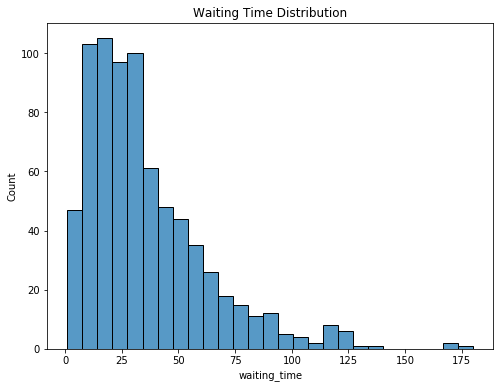

In [45]:
plt.figure(figsize = (8,6));
sns.histplot(data = avg_waiting_operator, x= 'waiting_time' );
plt.title('Waiting Time Distribution');
plt.show();

In [46]:
avg_waiting_operator['waiting_time'].mean()

35.83622255320988

- as we can see, the distribution is a bit skewed
- 50% of the operators have average daily waiting time for about 30 Seconds
- as we have some high values the average is higher than the median with 35 Seconds
- there are some operators with a high average daily waiting time reaching 180 Seconds

In [47]:
np.percentile(avg_waiting_operator['waiting_time'], [85, 90, 95, 96, 97, 98, 99, 99.5, 99.9])

array([ 59.97      ,  71.6       ,  88.25756303,  93.09236364,
       102.41      , 115.47933333, 123.76153846, 130.52444444,
       173.241     ])

In [48]:
data_clean.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
1,166377,2019-08-05,out,True,880022.0,True,3,0,5,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18,8
4,166377,2019-08-05,out,False,880022.0,True,3,0,25,25
5,166377,2019-08-05,out,False,880020.0,False,2,3,29,26


- to prepare for the next calculation we will make a new dataset that contains the values that we need.
- we will start with the number of calls for the operators per date split into incoming / outgoind and answered / missed. 
- we will then create new caolumns for `total_calls`, `total_incoming_calls` and `total_outgoing_calls`
- we will make then another dataset for the number of calls for the operators per date split into internal / external
- after that we will join both datasetes together and with `waiting_operator_date` to have all aggregated information in one dataset
- in the end we will create another 2 new columns for `percentage_outgoing_calls` and `percentage_external_calls`

In [49]:
# number of calls for the operators per date split into incoming / outgoind and answered / missed
calls_operator = data_clean.pivot_table(index = ['operator_id', 'date'], columns= ['direction', 'is_missed_call'] , values='calls_count', aggfunc='sum').reset_index().fillna(0)
calls_operator

direction      operator_id       date    in        out      
is_missed_call                        False True False  True
0                 879896.0 2019-08-02   0.0  0.0   5.0   8.0
1                 879896.0 2019-08-03   1.0  0.0   3.0   7.0
2                 879896.0 2019-08-04   0.0  0.0   1.0   1.0
3                 879896.0 2019-08-05   1.0  0.0   2.0   1.0
4                 879896.0 2019-08-06   6.0  0.0   3.0   8.0
...                    ...        ...   ...  ...   ...   ...
16294             972410.0 2019-11-27   0.0  0.0   0.0  11.0
16295             972412.0 2019-11-27   1.0  0.0   0.0   0.0
16296             972460.0 2019-11-27   1.0  0.0   4.0   7.0
16297             973120.0 2019-11-27   0.0  0.0   1.0   2.0
16298             973286.0 2019-11-28   2.0  0.0   0.0   0.0

[16299 rows x 6 columns]

In [50]:
# renaming the columns
calls_operator.columns = ['operator_id', 'date', 'in_answered', 'in_missed', 'out_answered', 'out_missed']
calls_operator.head()

,operator_id,date,in_answered,in_missed,out_answered,out_missed
0,879896.0,2019-08-02,0.0,0.0,5.0,8.0
1,879896.0,2019-08-03,1.0,0.0,3.0,7.0
2,879896.0,2019-08-04,0.0,0.0,1.0,1.0
3,879896.0,2019-08-05,1.0,0.0,2.0,1.0
4,879896.0,2019-08-06,6.0,0.0,3.0,8.0


In [51]:
# creating new columns
calls_operator['total_calls'] = calls_operator['in_answered'] + calls_operator['in_missed'] + calls_operator['out_answered'] + calls_operator['out_missed']
calls_operator['incoming_calls'] = calls_operator['in_answered'] + calls_operator['in_missed']
calls_operator['outgoing_calls'] = calls_operator['out_answered'] + calls_operator['out_missed']
calls_operator.head()

,operator_id,date,in_answered,in_missed,out_answered,out_missed,total_calls,incoming_calls,outgoing_calls
0,879896.0,2019-08-02,0.0,0.0,5.0,8.0,13.0,0.0,13.0
1,879896.0,2019-08-03,1.0,0.0,3.0,7.0,11.0,1.0,10.0
2,879896.0,2019-08-04,0.0,0.0,1.0,1.0,2.0,0.0,2.0
3,879896.0,2019-08-05,1.0,0.0,2.0,1.0,4.0,1.0,3.0
4,879896.0,2019-08-06,6.0,0.0,3.0,8.0,17.0,6.0,11.0


In [52]:
# number of calls for the operators per date split into internal / external
internal_external = data_clean.pivot_table(index = ['operator_id', 'date'], columns= ['internal'] , values='calls_count', aggfunc='sum').reset_index().fillna(0)
internal_external

internal,operator_id,date,False,True
0,879896.0,2019-08-02,11.0,2.0
1,879896.0,2019-08-03,11.0,0.0
2,879896.0,2019-08-04,2.0,0.0
3,879896.0,2019-08-05,2.0,2.0
4,879896.0,2019-08-06,13.0,4.0
...,...,...,...,...
16294,972410.0,2019-11-27,11.0,0.0
16295,972412.0,2019-11-27,1.0,0.0
16296,972460.0,2019-11-27,9.0,3.0
16297,973120.0,2019-11-27,3.0,0.0


In [53]:
# renaming the columns
internal_external.columns = ['operator_id', 'date', 'internal_calls', 'external_calls']
internal_external.head()

,operator_id,date,internal_calls,external_calls
0,879896.0,2019-08-02,11.0,2.0
1,879896.0,2019-08-03,11.0,0.0
2,879896.0,2019-08-04,2.0,0.0
3,879896.0,2019-08-05,2.0,2.0
4,879896.0,2019-08-06,13.0,4.0


In [54]:
# merging all datasets
final = pd.merge(left = waiting_operator_date, right= calls_operator , left_on= ['operator_id', 'date'], right_on= ['operator_id', 'date'], how= 'right')
final = pd.merge(left = final, right= internal_external , left_on= ['operator_id', 'date'], right_on= ['operator_id', 'date'], how= 'left')
final.head()

,operator_id,date,waiting_time,in_answered,in_missed,out_answered,out_missed,total_calls,incoming_calls,outgoing_calls,internal_calls,external_calls
0,879896.0,2019-08-02,NaN,0.0,0.0,5.0,8.0,13.0,0.0,13.0,11.0,2.0
1,879896.0,2019-08-03,9.0,1.0,0.0,3.0,7.0,11.0,1.0,10.0,11.0,0.0
2,879896.0,2019-08-04,NaN,0.0,0.0,1.0,1.0,2.0,0.0,2.0,2.0,0.0
3,879896.0,2019-08-05,10.0,1.0,0.0,2.0,1.0,4.0,1.0,3.0,2.0,2.0
4,879896.0,2019-08-06,39.0,6.0,0.0,3.0,8.0,17.0,6.0,11.0,13.0,4.0


In [55]:
# creating the last 2 new columns
final['ext_pct'] = (final['external_calls'] / final['total_calls']) *100
final['out_pct'] = (final['outgoing_calls'] / final['total_calls']) *100
final.head()

,operator_id,date,waiting_time,in_answered,in_missed,out_answered,out_missed,total_calls,incoming_calls,outgoing_calls,internal_calls,external_calls,ext_pct,out_pct
0,879896.0,2019-08-02,NaN,0.0,0.0,5.0,8.0,13.0,0.0,13.0,11.0,2.0,15.384615,100.000000
1,879896.0,2019-08-03,9.0,1.0,0.0,3.0,7.0,11.0,1.0,10.0,11.0,0.0,0.000000,90.909091
2,879896.0,2019-08-04,NaN,0.0,0.0,1.0,1.0,2.0,0.0,2.0,2.0,0.0,0.000000,100.000000
3,879896.0,2019-08-05,10.0,1.0,0.0,2.0,1.0,4.0,1.0,3.0,2.0,2.0,50.000000,75.000000
4,879896.0,2019-08-06,39.0,6.0,0.0,3.0,8.0,17.0,6.0,11.0,13.0,4.0,23.529412,64.705882


now that all information is ready we will continue with the study

### Find average daily missed calls per operator (for incoming calls)

- as we are intenrested only in the incoming missed calls so we will study only the operators and entries who had incoming calls and then we will find the daily average for every operator

In [56]:
daily_average_in_call = final[final['incoming_calls'] != 0].groupby('operator_id')[['in_missed', 'incoming_calls']].mean().reset_index()
daily_average_in_call

,operator_id,in_missed,incoming_calls
0,879896.0,0.0,2.850000
1,879898.0,0.0,1.759259
2,880020.0,0.0,1.000000
3,880022.0,0.0,1.000000
4,880026.0,0.0,1.333333
...,...,...,...
747,971102.0,0.0,2.000000
748,971354.0,0.0,3.000000
749,972412.0,0.0,1.000000
750,972460.0,0.0,1.000000


In [57]:
daily_average_in_call['in_missed'].describe()

count    752.000000
mean       0.093952
std        0.264612
min        0.000000
25%        0.000000
50%        0.000000
75%        0.052987
max        3.000000
Name: in_missed, dtype: float64

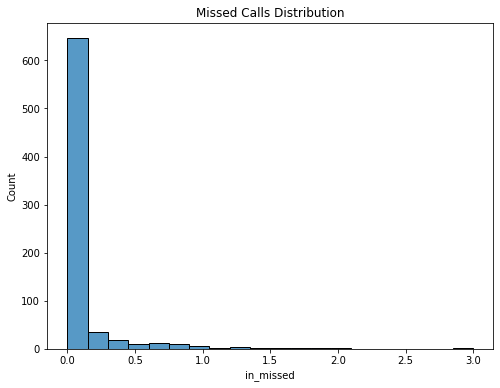

In [58]:
plt.figure(figsize = (8,6));
sns.histplot(data = daily_average_in_call, x= 'in_missed', bins=20);
plt.title('Missed Calls Distribution');
plt.show();

- from the Hist and describe we see that more than 50% of the operators have an average daily missed calls of 0
- the overall average daily missed calls for all operators is 0.09 which can be interpreted as 1 missed call every 10 days
- we have some operators with a high average daily missed calls count reaching 3 missed calls every day

In [59]:
daily_average_in_call['incoming_calls'].describe()

count    752.000000
mean       2.365538
std        2.013260
min        1.000000
25%        1.200000
50%        1.777778
75%        3.000000
max       31.000000
Name: incoming_calls, dtype: float64

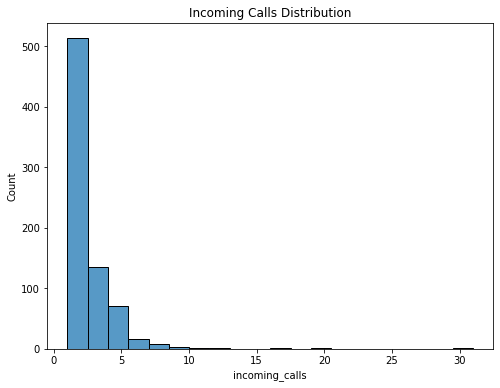

In [60]:
plt.figure(figsize = (8,6));
sns.histplot(data = daily_average_in_call, x= 'incoming_calls', bins=20);
plt.title('Incoming Calls Distribution');
plt.show();

- we see that 50% of the operators have an average daily incoming calls of no more than 1.7 call
- the overall average for all operators is 2.35 calls
- we have some high averages reaching 20 and even 31 calls

now lets take a look at the overall outgoing calls before checking the percentages

In [61]:
daily_out_call = final[final['outgoing_calls'] != 0].groupby('operator_id')['outgoing_calls'].mean().reset_index()
daily_out_call

,operator_id,outgoing_calls
0,879896.0,4.933333
1,879898.0,5.541667
2,880020.0,5.428571
3,880022.0,3.764706
4,880026.0,6.650000
...,...,...
841,970486.0,3.000000
842,972408.0,6.000000
843,972410.0,11.000000
844,972460.0,11.000000


In [62]:
daily_out_call['outgoing_calls'].describe()

count    846.000000
mean       4.368543
std        2.855789
min        1.000000
25%        2.000000
50%        3.755000
75%        6.000000
max       18.000000
Name: outgoing_calls, dtype: float64

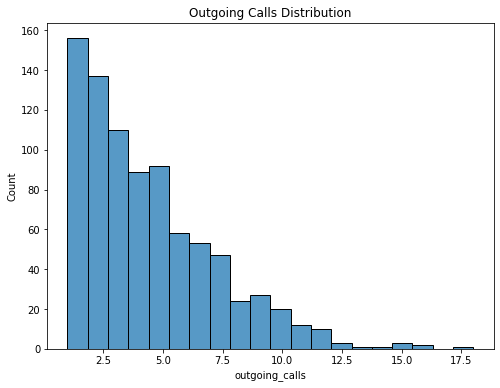

In [63]:
plt.figure(figsize = (8,6));
sns.histplot(data = daily_out_call, x= 'outgoing_calls', bins=20);
plt.title('Outgoing Calls Distribution');
plt.show();

- we see that 50% of the operators have an average daily outgoing calls of no more than 3.75 calls
- the overall average for all operators is 4.36 calls
- we have some high averages reaching 18 calls

### Find average daily number of calls per operator (in + out)

now lets check the total number of calsl for every operator

In [64]:
avg_calls_operator = final.groupby('operator_id').mean().reset_index()
avg_calls_operator.head()

,operator_id,waiting_time,in_answered,in_missed,out_answered,out_missed,total_calls,incoming_calls,outgoing_calls,internal_calls,external_calls,ext_pct,out_pct
0,879896.0,28.450000,1.187500,0.0,2.270833,2.354167,5.812500,1.187500,4.625000,4.645833,1.166667,11.113288,81.292574
1,879898.0,20.666667,1.397059,0.0,0.691176,1.264706,3.352941,1.397059,1.955882,3.088235,0.264706,13.033964,29.703395
2,880020.0,7.714286,0.500000,0.0,1.142857,1.571429,3.214286,0.500000,2.714286,2.928571,0.285714,4.761905,50.000000
3,880022.0,14.000000,0.200000,0.0,1.650000,1.550000,3.400000,0.200000,3.200000,3.025000,0.375000,7.875000,83.809524
4,880026.0,7.944444,0.369231,0.0,0.476923,5.661538,6.507692,0.369231,6.138462,6.200000,0.307692,12.472782,87.637252


In [65]:
avg_calls_operator['total_calls'].describe()

count    1060.000000
mean        4.148827
std         3.047366
min         1.000000
25%         1.785714
50%         3.258094
75%         5.765582
max        18.500000
Name: total_calls, dtype: float64

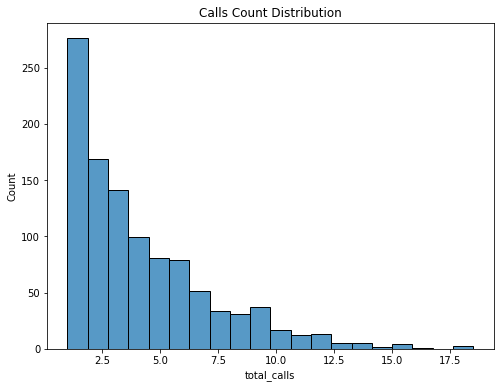

In [66]:
plt.figure(figsize = (8,6));
sns.histplot(data = avg_calls_operator, x= 'total_calls', bins=20);
plt.title('Calls Count Distribution');
plt.show();

- we see that 50% of the operators have an average daily calls of around 1.8 call
- the overall average for all operators is 4.1 calls
- we have some high averages reaching 18 calls
- the distribution of the total calls looks pretty similar to the distribution of outgoing calls

### Find average percentage of daily outgoing calls per operator

lets see the daily average percentage of daily outgoing calls per operator

In [67]:
avg_calls_operator['out_pct'].describe()

count    1060.000000
mean       59.001603
std        38.905361
min         0.000000
25%        20.970332
50%        66.666667
75%       100.000000
max       100.000000
Name: out_pct, dtype: float64

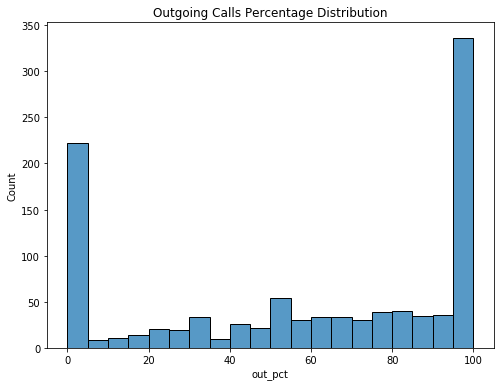

In [68]:
plt.figure(figsize = (8,6));
sns.histplot(data = avg_calls_operator, x= 'out_pct', bins=20);
plt.title('Outgoing Calls Percentage Distribution');
plt.show();

- we can see that at least 50% of the oprators have an average outgoing calls share of at least 66% which means that the operators calls more than they answer
- on average the opertaors have 59% share of outgoing calls
- the operators can be split into 3 groups which we should take intop consideration when identifying the ineffective opertaors:
    1. Only outgoing calls: have an average outgoing calls share of 100%  
    2. Only incoming calls: have an average outgoing calls share of 0% 
    3. both kinds of calls: have differnt average outgoing calls share values ranging fom 1% to 99% 

Now before we check the scatter lets see acorrelation Matrix between all metrics

In [69]:
final.corr()

,operator_id,waiting_time,in_answered,in_missed,out_answered,out_missed,total_calls,incoming_calls,outgoing_calls,internal_calls,external_calls,ext_pct,out_pct
operator_id,1.000000,-0.003438,0.045723,0.060945,0.027816,-0.048580,0.013308,0.053148,-0.014137,0.007548,0.015259,0.043924,-0.048765
waiting_time,-0.003438,1.000000,0.556558,0.080849,0.068630,0.039733,0.342981,0.567509,0.068131,0.347540,0.063709,-0.034365,-0.070936
in_answered,0.045723,0.556558,1.000000,0.034127,-0.044937,-0.055219,0.427201,0.991296,-0.066052,0.481709,-0.061542,-0.191879,-0.484663
in_missed,0.060945,0.080849,0.034127,1.000000,-0.026503,-0.018659,0.054359,0.165409,-0.029710,0.049136,0.020171,-0.023877,-0.115944
out_answered,0.027816,0.068630,-0.044937,-0.026503,1.000000,0.151671,0.659099,-0.047835,0.753755,0.521160,0.416397,0.122020,0.396747
out_missed,-0.048580,0.039733,-0.055219,-0.018659,0.151671,1.000000,0.663788,-0.056948,0.763876,0.612208,0.218215,-0.008502,0.404986
total_calls,0.013308,0.342981,0.427201,0.054359,0.659099,0.663788,1.000000,0.428723,0.871655,0.913471,0.349061,-0.027541,0.235953
incoming_calls,0.053148,0.567509,0.991296,0.165409,-0.047835,-0.056948,0.428723,1.000000,-0.069094,0.481823,-0.058073,-0.192491,-0.493539
outgoing_calls,-0.014137,0.068131,-0.066052,-0.029710,0.753755,0.763876,0.871655,-0.069094,1.000000,0.747299,0.416952,0.074016,0.528297
internal_calls,0.007548,0.347540,0.481709,0.049136,0.521160,0.612208,0.913471,0.481823,0.747299,1.000000,-0.062452,-0.305250,0.146997


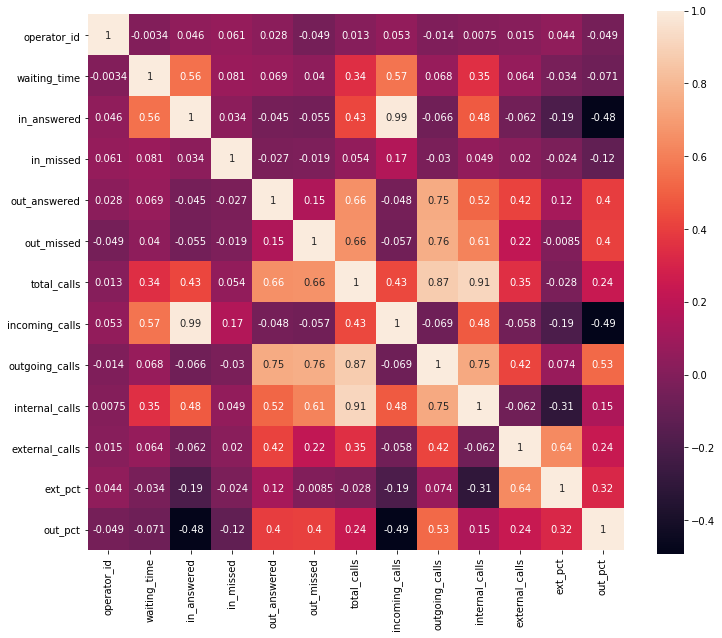

In [70]:
plt.figure(figsize = (12,10))
sns.heatmap(final.corr(), annot = True, square=True);

We will note only what is relevant:
1. there is no correlation (very weak correlation) between number of incoming calls and number of incoming missed calls
2. there is a correlation between the share of external/internal calls and number of outgoing calls
3. there is a small normal correlation between waiting time and number of incoming an total calls 
4. there is no correlation between number of missed calls and waiting time

### Scatter between missed calls and waiting time per operator

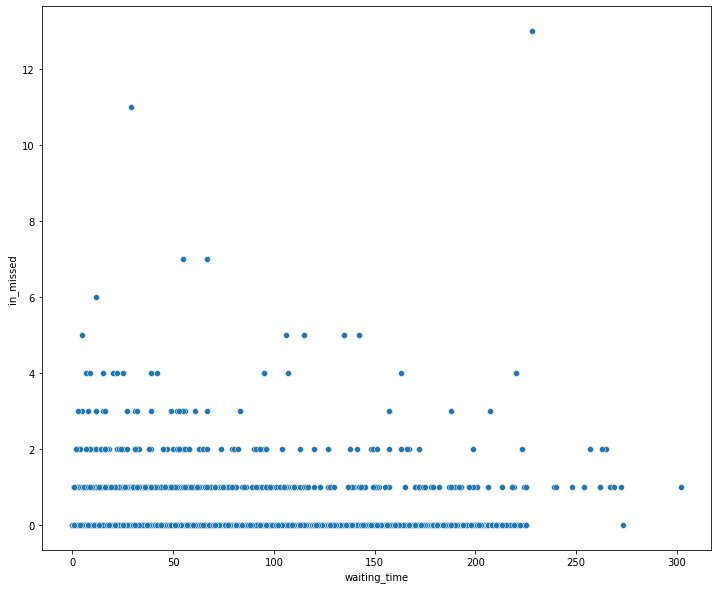

In [71]:
plt.figure(figsize = (12,10))
sns.scatterplot(x = 'waiting_time', y='in_missed', data = final);

as we said before after checking the correlation matrix there is no relation betrween waiting time and number of incoming missed calls

### Compare internal and external number of calls per operator

In [72]:
final.head()

,operator_id,date,waiting_time,in_answered,in_missed,out_answered,out_missed,total_calls,incoming_calls,outgoing_calls,internal_calls,external_calls,ext_pct,out_pct
0,879896.0,2019-08-02,NaN,0.0,0.0,5.0,8.0,13.0,0.0,13.0,11.0,2.0,15.384615,100.000000
1,879896.0,2019-08-03,9.0,1.0,0.0,3.0,7.0,11.0,1.0,10.0,11.0,0.0,0.000000,90.909091
2,879896.0,2019-08-04,NaN,0.0,0.0,1.0,1.0,2.0,0.0,2.0,2.0,0.0,0.000000,100.000000
3,879896.0,2019-08-05,10.0,1.0,0.0,2.0,1.0,4.0,1.0,3.0,2.0,2.0,50.000000,75.000000
4,879896.0,2019-08-06,39.0,6.0,0.0,3.0,8.0,17.0,6.0,11.0,13.0,4.0,23.529412,64.705882


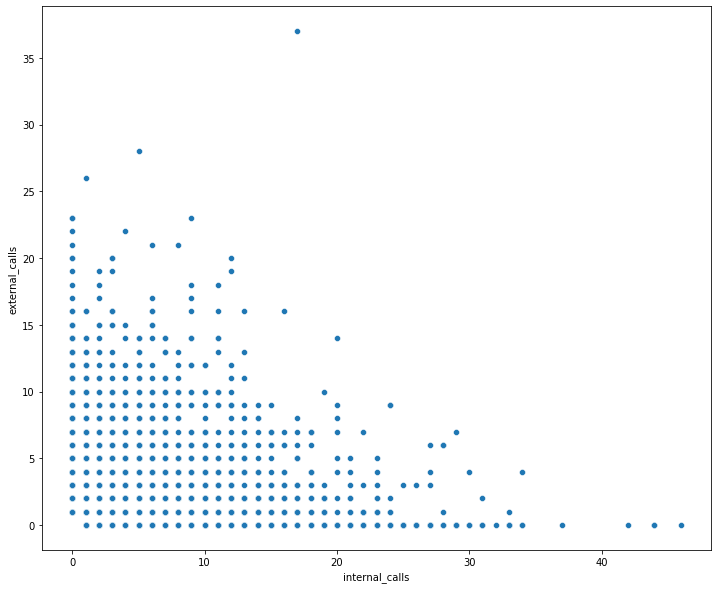

In [73]:
plt.figure(figsize = (12,10))
sns.scatterplot(x = 'internal_calls', y='external_calls', data = final);

we can see from the scatter as well as the correlation matrix that there is no correlation between the number of internal calls and number of external calls for the operators

### Identify the ineffective operators

as we said before the operators can be split into 3 groups which will be considered when setting the rules for the ineffective operators and these groups are:
   1. Only outgoing calls
   2. Only incoming calls
   3. both kinds of calls  

so we will split the data based on these groups and then we will talk about the rules for the ineffective operator

In [74]:
avg_calls_operator

,operator_id,waiting_time,in_answered,in_missed,out_answered,out_missed,total_calls,incoming_calls,outgoing_calls,internal_calls,external_calls,ext_pct,out_pct
0,879896.0,28.450000,1.187500,0.0,2.270833,2.354167,5.812500,1.187500,4.625000,4.645833,1.166667,11.113288,81.292574
1,879898.0,20.666667,1.397059,0.0,0.691176,1.264706,3.352941,1.397059,1.955882,3.088235,0.264706,13.033964,29.703395
2,880020.0,7.714286,0.500000,0.0,1.142857,1.571429,3.214286,0.500000,2.714286,2.928571,0.285714,4.761905,50.000000
3,880022.0,14.000000,0.200000,0.0,1.650000,1.550000,3.400000,0.200000,3.200000,3.025000,0.375000,7.875000,83.809524
4,880026.0,7.944444,0.369231,0.0,0.476923,5.661538,6.507692,0.369231,6.138462,6.200000,0.307692,12.472782,87.637252
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,972410.0,NaN,0.000000,0.0,0.000000,11.000000,11.000000,0.000000,11.000000,11.000000,0.000000,0.000000,100.000000
1056,972412.0,25.000000,1.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1057,972460.0,4.000000,1.000000,0.0,4.000000,7.000000,12.000000,1.000000,11.000000,9.000000,3.000000,25.000000,91.666667
1058,973120.0,NaN,0.000000,0.0,1.000000,2.000000,3.000000,0.000000,3.000000,3.000000,0.000000,0.000000,100.000000


In [75]:
just_in_calls = avg_calls_operator[(avg_calls_operator['incoming_calls'] != 0) & (avg_calls_operator['outgoing_calls'] == 0)]
just_out_calls = avg_calls_operator[(avg_calls_operator['incoming_calls'] == 0) & (avg_calls_operator['outgoing_calls'] != 0)]
both_calls = avg_calls_operator[(avg_calls_operator['incoming_calls'] != 0) & (avg_calls_operator['outgoing_calls'] != 0)]

In [76]:
just_in_calls

,operator_id,waiting_time,in_answered,in_missed,out_answered,out_missed,total_calls,incoming_calls,outgoing_calls,internal_calls,external_calls,ext_pct,out_pct
8,882476.0,31.666667,1.000000,0.000,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.00,0.000,0.0
10,882680.0,39.775000,2.400000,0.075,0.0,0.0,2.475000,2.475000,0.0,2.425000,0.05,3.125,0.0
19,884294.0,6.000000,1.000000,0.000,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.00,0.000,0.0
25,884524.0,9.500000,1.000000,0.000,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.00,0.000,0.0
31,886674.0,18.666667,1.222222,0.000,0.0,0.0,1.222222,1.222222,0.0,1.222222,0.00,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,971100.0,13.000000,1.500000,0.000,0.0,0.0,1.500000,1.500000,0.0,1.500000,0.00,0.000,0.0
1052,971102.0,18.000000,2.000000,0.000,0.0,0.0,2.000000,2.000000,0.0,2.000000,0.00,0.000,0.0
1053,971354.0,42.000000,3.000000,0.000,0.0,0.0,3.000000,3.000000,0.0,3.000000,0.00,0.000,0.0
1056,972412.0,25.000000,1.000000,0.000,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.00,0.000,0.0


In [77]:
just_out_calls

,operator_id,waiting_time,in_answered,in_missed,out_answered,out_missed,total_calls,incoming_calls,outgoing_calls,internal_calls,external_calls,ext_pct,out_pct
6,880240.0,NaN,0.0,0.0,1.0,2.428571,3.428571,0.0,3.428571,2.571429,0.857143,37.142857,100.0
7,881278.0,NaN,0.0,0.0,0.6,3.400000,4.000000,0.0,4.000000,2.400000,1.600000,30.666667,100.0
15,883018.0,NaN,0.0,0.0,0.0,2.000000,2.000000,0.0,2.000000,2.000000,0.000000,0.000000,100.0
16,883898.0,NaN,0.0,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,100.0
20,884402.0,NaN,0.0,0.0,3.0,1.000000,4.000000,0.0,4.000000,1.000000,3.000000,75.000000,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,970484.0,NaN,0.0,0.0,1.0,2.500000,3.500000,0.0,3.500000,3.500000,0.000000,0.000000,100.0
1050,970486.0,NaN,0.0,0.0,2.0,1.000000,3.000000,0.0,3.000000,3.000000,0.000000,0.000000,100.0
1054,972408.0,NaN,0.0,0.0,4.0,2.000000,6.000000,0.0,6.000000,6.000000,0.000000,0.000000,100.0
1055,972410.0,NaN,0.0,0.0,0.0,11.000000,11.000000,0.0,11.000000,11.000000,0.000000,0.000000,100.0


In [78]:
both_calls

,operator_id,waiting_time,in_answered,in_missed,out_answered,out_missed,total_calls,incoming_calls,outgoing_calls,internal_calls,external_calls,ext_pct,out_pct
0,879896.0,28.450000,1.187500,0.0,2.270833,2.354167,5.812500,1.187500,4.625000,4.645833,1.166667,11.113288,81.292574
1,879898.0,20.666667,1.397059,0.0,0.691176,1.264706,3.352941,1.397059,1.955882,3.088235,0.264706,13.033964,29.703395
2,880020.0,7.714286,0.500000,0.0,1.142857,1.571429,3.214286,0.500000,2.714286,2.928571,0.285714,4.761905,50.000000
3,880022.0,14.000000,0.200000,0.0,1.650000,1.550000,3.400000,0.200000,3.200000,3.025000,0.375000,7.875000,83.809524
4,880026.0,7.944444,0.369231,0.0,0.476923,5.661538,6.507692,0.369231,6.138462,6.200000,0.307692,12.472782,87.637252
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,970240.0,44.000000,1.000000,0.0,0.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,0.000000,50.000000
1044,970244.0,81.000000,2.000000,0.0,1.000000,1.000000,4.000000,2.000000,2.000000,3.000000,1.000000,25.000000,50.000000
1046,970252.0,25.000000,1.000000,0.0,2.000000,3.000000,6.000000,1.000000,5.000000,6.000000,0.000000,0.000000,83.333333
1047,970254.0,121.000000,3.000000,0.0,4.000000,5.000000,12.000000,3.000000,9.000000,9.000000,3.000000,25.000000,75.000000


Now lets talk about the ineffective operators and how will they be identified:
- we have three Metrics but not all of them can be applied to all groups thats why first we will set the threshold (redline) for every individual Metric as if it was the only thing that matters then we will adjust accordingly
    1. Waiting Time:  this applies only to the incoming calls as the 75% percentile is about 48 then we will goi a bit higher and consider that 60 a redline that should not be crossed and alone is enough to consider the operator ineffective
    2. Missed Calls: also applies only to the incoming calls and the same as Waiting Time we will take an average of 0.5 missed as a redline (0.5 means 1 missed call every 2 days) 
    3. Number Outgoing calls: this applies to operators who need to make calls not only answer them and when taken alone the number should be as high as possible, and as 25% percentile is around 2 so we will take this as  the redline  

 
<br>


- Now after we identified the thresholds for every metric we will start comibining them to sett the formula for the groups: 
    1. Only outgoing calls: here only 1 Metric `Outgoing calls` applies and will be taking alone (every operator who has an average daily of less than 2 outgoing calls will be conisdered ineffective)
    2. Only incoming calls: here we have 2 Metrics `Waiting Time` and `Missed Calls` so we will make a simple formula that use weights for both metrics  `ineffect_value = (W1 * Waiting Time) + (W2 * Missed Calls)`.  The Weights will be calculated from the Thresholds as follows  `W = 100 / Thrshold`
    3. Both Calls: Here all metrics apply which is why we will set a more lenient thresholds and will use a formula with weights:  `ineffect_value = (W1 * Waiting Time) + (W2 * Missed Calls) + (W3 * Outgoing calls)`. the weights will be calculated with the same way but we use the following thresholds:
        1. Waiting Time: 70 
        2. Missed Calls: 0.7
        3. Number Outgoing calls: 1.5  (Note: as in the outgoing number the more the better the weight here will be negative)  


<div class="alert alert-info"> <b>Note:</b> 
We used different thresholds here because the operator has more tasks therefore I thought the thresholds should be easier to fulfill than when the operators will have to focus on just one type of calls 
</div>



- after we calculate the `ineffect_value` we will take the operators who reach 100 and consider them ineffective

In [79]:
# adding the ineffective operators_id from the group 'Only outgoing calls' to a list
ineffective_id_out = just_out_calls[just_out_calls['outgoing_calls'] < 2]['operator_id'].to_list()
print('Number of ineffective operators in group A:',len(ineffective_id_out))

Number of ineffective operators in group A: 71


In [80]:
# applying the formula for 'Only incoming calls'
just_in_calls['ineffect_value'] = (just_in_calls['in_missed']* 200) + (just_in_calls['waiting_time']* 1.6)
just_in_calls.head()

/home/jovyan/.local/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,operator_id,waiting_time,in_answered,in_missed,out_answered,out_missed,total_calls,incoming_calls,outgoing_calls,internal_calls,external_calls,ext_pct,out_pct,ineffect_value
8,882476.0,31.666667,1.000000,0.000,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.00,0.000,0.0,50.666667
10,882680.0,39.775000,2.400000,0.075,0.0,0.0,2.475000,2.475000,0.0,2.425000,0.05,3.125,0.0,78.640000
19,884294.0,6.000000,1.000000,0.000,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.00,0.000,0.0,9.600000
25,884524.0,9.500000,1.000000,0.000,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.00,0.000,0.0,15.200000
31,886674.0,18.666667,1.222222,0.000,0.0,0.0,1.222222,1.222222,0.0,1.222222,0.00,0.000,0.0,29.866667


In [81]:
#adding the operators_id who reached the ineffect_valuies of 100 to list
ineffective_id_in = just_in_calls[just_in_calls['ineffect_value'] >= 100]['operator_id'].to_list()
print('Number of ineffective operators in group B:',len(ineffective_id_in))

Number of ineffective operators in group B: 37


In [82]:
# applying the formula for 'both calls'
both_calls['ineffect_value'] = (both_calls['in_missed']* 143) + (both_calls['waiting_time']* 1.43) - (both_calls['outgoing_calls'] * 66)
both_calls.head()

/home/jovyan/.local/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,operator_id,waiting_time,in_answered,in_missed,out_answered,out_missed,total_calls,incoming_calls,outgoing_calls,internal_calls,external_calls,ext_pct,out_pct,ineffect_value
0,879896.0,28.450000,1.187500,0.0,2.270833,2.354167,5.812500,1.187500,4.625000,4.645833,1.166667,11.113288,81.292574,-264.566500
1,879898.0,20.666667,1.397059,0.0,0.691176,1.264706,3.352941,1.397059,1.955882,3.088235,0.264706,13.033964,29.703395,-99.534902
2,880020.0,7.714286,0.500000,0.0,1.142857,1.571429,3.214286,0.500000,2.714286,2.928571,0.285714,4.761905,50.000000,-168.111429
3,880022.0,14.000000,0.200000,0.0,1.650000,1.550000,3.400000,0.200000,3.200000,3.025000,0.375000,7.875000,83.809524,-191.180000
4,880026.0,7.944444,0.369231,0.0,0.476923,5.661538,6.507692,0.369231,6.138462,6.200000,0.307692,12.472782,87.637252,-393.777906


<div class="alert alert-info"> <b>Student's comment:</b> 
I will explain my train of thoughts here, and how I arrived at this formula, hopefully I will be able to explain it well enough.  <br> <br>   
    - When the operator reaches the threshold or the "redline" he will get a full `ineffect_value` of 100 . That's why to find the weight of 1 Unit of that metric we used the simplest way, deviding the `ineffect_value`, which is 100, over the threshold.<br>
    - We have three Metrics but they don't have the same behavior: <br>
        1. Waiting Time: the less the better. Therefore the weight should be positive as it will increase the `ineffect_value`<br>
        2. Missed Calls: same as Waiting Time; the less the better. Therefore the weight should be positive as it will increase the `ineffect_value`<br>
        3. Outgoing calls: Here, the more the better. Therfore the weight should be negative which will descrease the `ineffect_value` the more the operator has Outgoing calls. <br>
    Because the weight should be negative and I used a positive one, the last sign in the formula `ineffect_value = (W1 * Waiting Time) + (W2 * Missed Calls) + (W3 * Outgoing calls)` will change. I think I could have just applied a negative value and left the sign as it is but from a mathematical perspective it is the same.
     
</div>

In [83]:
#adding the operators_id who reached the ineffect_valuies of 100 to list
ineffective_id_both = both_calls[both_calls['ineffect_value'] >= 100]['operator_id'].to_list()
print('Number of ineffective operators in group C:',len(ineffective_id_both))

Number of ineffective operators in group C: 14


In [84]:
# combining all list into one list with the operators_id of ineffective users
ineffective_id = ineffective_id_out + ineffective_id_in + ineffective_id_both

In [85]:
# creating new empty column in all relevant dataset
data_clean['ineffective'] = ''
final['ineffective'] = ''
avg_calls_operator['ineffective'] = ''

In [86]:
# filling the new column in all dataset to identify the ineffective operators based on the id in the list
data_clean['ineffective'] = data_clean['ineffective'].where(data_clean['operator_id'].isin(ineffective_id), False).mask(data_clean['operator_id'].isin(ineffective_id), True)
final['ineffective'] = final['ineffective'].where(final['operator_id'].isin(ineffective_id), False).mask(final['operator_id'].isin(ineffective_id), True)
avg_calls_operator['ineffective'] = avg_calls_operator['ineffective'].where(avg_calls_operator['operator_id'].isin(ineffective_id), False).mask(avg_calls_operator['operator_id'].isin(ineffective_id), True)

In [87]:
avg_calls_operator.head()

,operator_id,waiting_time,in_answered,in_missed,out_answered,out_missed,total_calls,incoming_calls,outgoing_calls,internal_calls,external_calls,ext_pct,out_pct,ineffective
0,879896.0,28.450000,1.187500,0.0,2.270833,2.354167,5.812500,1.187500,4.625000,4.645833,1.166667,11.113288,81.292574,False
1,879898.0,20.666667,1.397059,0.0,0.691176,1.264706,3.352941,1.397059,1.955882,3.088235,0.264706,13.033964,29.703395,False
2,880020.0,7.714286,0.500000,0.0,1.142857,1.571429,3.214286,0.500000,2.714286,2.928571,0.285714,4.761905,50.000000,False
3,880022.0,14.000000,0.200000,0.0,1.650000,1.550000,3.400000,0.200000,3.200000,3.025000,0.375000,7.875000,83.809524,False
4,880026.0,7.944444,0.369231,0.0,0.476923,5.661538,6.507692,0.369231,6.138462,6.200000,0.307692,12.472782,87.637252,False


In [88]:
print('Number of overall ineffective operators:',len(ineffective_id))

Number of overall ineffective operators: 122


In [89]:
print('percentage of overall ineffective operators:', '{:0.2%}'.format(len(ineffective_id) / avg_calls_operator['operator_id'].nunique()))

percentage of overall ineffective operators: 11.51%


- We identified 122 ineffective operators who make around 11% of all operators

## Test statistical hypotheses:

- before testing the hypthesis we will split the data into 2 sets: effective and ineffective

In [90]:
effective = avg_calls_operator[avg_calls_operator['ineffective'] == False]
ineffective = avg_calls_operator[avg_calls_operator['ineffective'] == True]

In [91]:
effective.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 938 entries, 0 to 1058
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   operator_id     938 non-null    float64
 1   waiting_time    701 non-null    float64
 2   in_answered     938 non-null    float64
 3   in_missed       938 non-null    float64
 4   out_answered    938 non-null    float64
 5   out_missed      938 non-null    float64
 6   total_calls     938 non-null    float64
 7   incoming_calls  938 non-null    float64
 8   outgoing_calls  938 non-null    float64
 9   internal_calls  938 non-null    float64
 10  external_calls  938 non-null    float64
 11  ext_pct         938 non-null    float64
 12  out_pct         938 non-null    float64
 13  ineffective     938 non-null    object 
dtypes: float64(13), object(1)
memory usage: 109.9+ KB


In [92]:
ineffective.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122 entries, 16 to 1059
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   operator_id     122 non-null    float64
 1   waiting_time    51 non-null     float64
 2   in_answered     122 non-null    float64
 3   in_missed       122 non-null    float64
 4   out_answered    122 non-null    float64
 5   out_missed      122 non-null    float64
 6   total_calls     122 non-null    float64
 7   incoming_calls  122 non-null    float64
 8   outgoing_calls  122 non-null    float64
 9   internal_calls  122 non-null    float64
 10  external_calls  122 non-null    float64
 11  ext_pct         122 non-null    float64
 12  out_pct         122 non-null    float64
 13  ineffective     122 non-null    object 
dtypes: float64(13), object(1)
memory usage: 14.3+ KB


## Share of incoming and outgoing calls are the same for effective and ineffective operators 

lets check if our data is distributed normally and for that we will use shapiro Test.

we will test both datasets and our hypothesises will be:

- H0: dataset is distributed normaly 
- H1: dataset is NOT distributed normaly  

we will use a standard critical statistical significance level (alpha= 0.05)

In [93]:
alpha = 0.05

eff_normality = st.shapiro(effective['ext_pct'])

print('p-value: ', eff_normality.pvalue)

if (eff_normality.pvalue > alpha):
    print('Data looks Normal (fail to reject H0)')
else:
    print('Data does not look Normal (reject H0)')   

p-value:  9.318165352774485e-39
Data does not look Normal (reject H0)


In [94]:
alpha = 0.05

ineff_normality = st.shapiro(ineffective['ext_pct'])

print('p-value: ', ineff_normality.pvalue)

if (ineff_normality.pvalue > alpha):
    print('Data looks Normal (fail to reject H0)')
else:
    print('Data does not look Normal (reject H0)') 

p-value:  6.810158130814376e-16
Data does not look Normal (reject H0)


Based on the tests above we see that both of our datasets don't look normal so we will use Levene-Test to check if the variances are equal on both sets.

for this this test we will be forming the following hypothesis:
- H0: Variances are equal
- H1: Variances are Different 

we will use a standard critical statistical significance level (alpha= 0.05)  

- to decide which variation of the Test we will use lets take a look at the hist for both of the sets and then we will decide as follows:  
1. median: recommended for skewed distributions.
2. mean: recommended for symmetric, moderate-tailed distributions.
3. trimmed: recommended for heavy-tailed distributions.

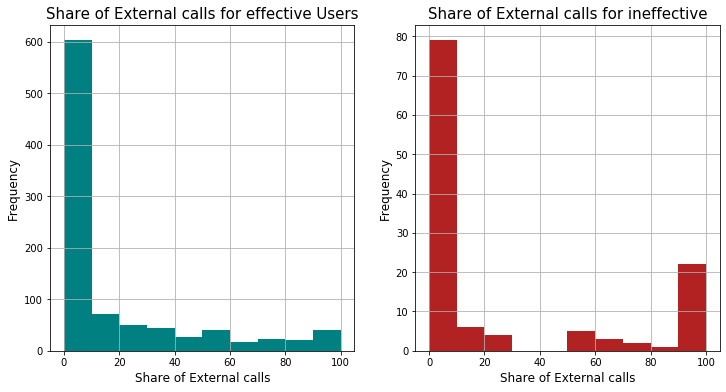

In [95]:
plt.figure(figsize = (12,6));
plt.subplot(1, 2, 1);
fig1 = effective['ext_pct'].hist(color = 'teal');
plt.title('Share of External calls for effective Users', fontsize = 15);
fig1.set_ylabel("Frequency", fontsize=12);
fig1.set_xlabel("Share of External calls", fontsize=12);

plt.subplot(1, 2, 2);
fig2 = ineffective['ext_pct'].hist(color = 'firebrick');
plt.title('Share of External calls for ineffective', fontsize = 15);
fig2.set_ylabel("Frequency", fontsize=12);
fig2.set_xlabel("Share of External calls", fontsize=12);

Based on the Hists above we can see that both of our sets are heavy-tailed so we will use the 'trimmed' Variation 

In [96]:
alpha = 0.05

variance_equality = st.levene(effective['ext_pct'], ineffective['ext_pct'] , center = 'trimmed')

print('p-value: ', variance_equality.pvalue)

if (variance_equality.pvalue < alpha):
        print("We reject the null hypothesis and the variances are different ")
else:
        print("We can't reject the null hypothesis therefore the variances are equal") 

p-value:  2.1965426818900535e-19
We reject the null hypothesis and the variances are different 


We rejected the null hypothesis so we will consider that the variances in both datasets are not equal and now we check our main Hypothesis using Student-Test with consideration that the variances are not equal.

Our hypothesis is: ***share of external / internal calls is the same for effective and ineffective operators.***

for this this test we will be forming the following hypothesis:
- H0: Share of external calls for effective == Share of external calls for ineffective
- H1: Share of external calls for effective != Share of external calls for ineffective

we will use a standard critical statistical significance level (alpha= 0.05) 

In [97]:
alpha = 0.05

results = st.ttest_ind(effective['ext_pct'], ineffective['ext_pct'], equal_var = False)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis and the Share of external calls for effective and ineffective operators is not the same")
else:
        print("We can't reject the null hypothesis therefore we can't say that the Share of external calls for effective and ineffective operators is different") 

p-value:  0.029815707498525416
We reject the null hypothesis and the Share of external calls for effective and ineffective operators is not the same


## Share of incoming and outgoing calls are the same for effective and ineffective operators 

lets check if our data is distributed normally and for that we will use shapiro Test.

we will test both datasets and our hypothesises will be:

- H0: dataset is distributed normaly 
- H1: dataset is NOT distributed normaly  

we will use a standard critical statistical significance level (alpha= 0.05)

In [98]:
alpha = 0.05

eff_normality = st.shapiro(effective['out_pct'])

print('p-value: ', eff_normality.pvalue)

if (eff_normality.pvalue > alpha):
    print('Data looks Normal (fail to reject H0)')
else:
    print('Data does not look Normal (reject H0)')   

p-value:  1.9685974778576768e-28
Data does not look Normal (reject H0)


In [99]:
alpha = 0.05

ineff_normality = st.shapiro(ineffective['out_pct'])

print('p-value: ', ineff_normality.pvalue)

if (ineff_normality.pvalue > alpha):
    print('Data looks Normal (fail to reject H0)')
else:
    print('Data does not look Normal (reject H0)') 

p-value:  2.0101004516345214e-15
Data does not look Normal (reject H0)


Based on the tests above we see that both of our datasets don't look normal so we will use Levene-Test to check if the variances are equal on both sets.

for this this test we will be forming the following hypothesis:
- H0: Variances are equal
- H1: Variances are Different 

we will use a standard critical statistical significance level (alpha= 0.05)  

- to decide which variation of the Test we will use lets take a look at the hist for both of the sets and then we will decide as follows:  
1. median: recommended for skewed distributions.
2. mean: recommended for symmetric, moderate-tailed distributions.
3. trimmed: recommended for heavy-tailed distributions.

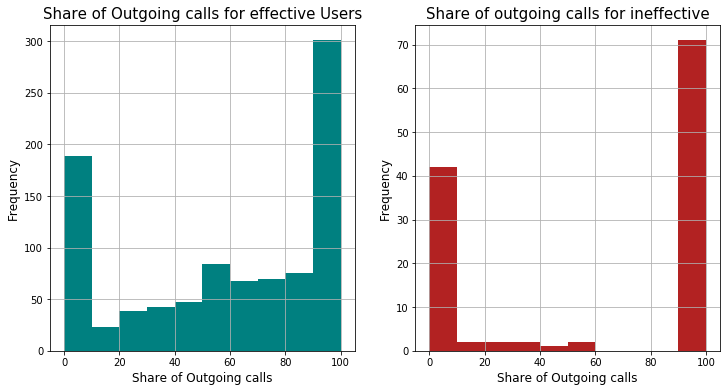

In [100]:
plt.figure(figsize = (12,6));
plt.subplot(1, 2, 1);
fig1 = effective['out_pct'].hist(color = 'teal');
plt.title('Share of Outgoing calls for effective Users', fontsize = 15);
fig1.set_ylabel("Frequency", fontsize=12);
fig1.set_xlabel("Share of Outgoing calls", fontsize=12);

plt.subplot(1, 2, 2);
fig2 = ineffective['out_pct'].hist(color = 'firebrick');
plt.title('Share of outgoing calls for ineffective', fontsize = 15);
fig2.set_ylabel("Frequency", fontsize=12);
fig2.set_xlabel("Share of Outgoing calls", fontsize=12);

Based on the Hists above we can see that both of our sets are heavy-tailed so we will use the 'trimmed' Variation 

In [101]:
alpha = 0.05

variance_equality = st.levene(effective['out_pct'], ineffective['out_pct'] , center = 'trimmed')

print('p-value: ', variance_equality.pvalue)

if (variance_equality.pvalue < alpha):
        print("We reject the null hypothesis and the variances are different ")
else:
        print("We can't reject the null hypothesis therefore the variances are equal") 

p-value:  1.4007084052045724e-14
We reject the null hypothesis and the variances are different 


We rejected the null hypothesis so we will consider that the variances in both datasets are not equal and now we check our main Hypothesis using Student-Test with consideration that the variances are not equal.

Our hypothesis is: ***share of outgoing / incoming calls is the same for effective and ineffective operators.***

for this this test we will be forming the following hypothesis:
- H0: Share of outgoing calls for effective == Share of outgoing calls for ineffective
- H1: Share of outgoing calls for effective != Share of outgoing calls for ineffective

we will use a standard critical statistical significance level (alpha= 0.05) 

In [102]:
alpha = 0.05

results = st.ttest_ind(effective['out_pct'], ineffective['out_pct'], equal_var = False)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis and the share of outgoing calls for effective and ineffective operators is not the same")
else:
        print("We can't reject the null hypothesis therefore we can't say that the share of outgoing calls for effective and ineffective operators is different") 

p-value:  0.6530066026596957
We can't reject the null hypothesis therefore we can't say that the share of outgoing calls for effective and ineffective operators is different


## Final Conclusions:

- 1060 operators were included in the final data that were studied
- Data was taken over four months but there was an obvious increase in calls in the last month
- Average daily waiting Time is around 36 Seconds
- Average daily missed calls is 0.09 missed call (1 missed call every 10 days)
- Average daily number of outgoing calls is 4.36 daily calls per operator
- Average daily number of calls (Total calls )is 4.1 daily calls per operator
- There is no correlation between three metrics used to identify the ineffective operators (which means they are independent and will not affect each other)
- 122 ineffective Operator were identified who make 11% of the total operators
- Ineffective operators are split into 3 groups based on call-types:
        A. Only outgoing calls
        B. Only incoming calls
        C. Both types of calls        
- Most of the ineffective operators were from Group A with 71 operator
- After testing there wasn't enough reason to say that the share of outgoing calls for effective and ineffective operators is different

### Recommendation:

- Better system for distributing tasks between operators
- Better system for distributing calls between operators
- Assign a minimum/maximum threshold for the relevant metrics and warn the operators who cross or close to crossing them

##### Dashboard:  
<https://public.tableau.com/app/profile/abdelrahman.tolaymat/viz/IneffectiveOperators/CallCountHistogram> 
<https://public.tableau.com/app/profile/abdelrahman.tolaymat/viz/IneffectiveOperators/CallCountStackedArea> 
<https://public.tableau.com/app/profile/abdelrahman.tolaymat/viz/IneffectiveOperators/CallCountBar> 

##### Documentaion:
1. **dt_localize**: to create a time zone unaware object from an aware object 
<https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.tz_localize.html> 
2. **Mask/Where**:  to assign values to a column based on condition (where: if condition is False / Mask: if Condition is True)
<https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.where.html> and <https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mask.html#pandas.DataFrame.mask>
3. **plt.savefig**: how to save the graphs as files to used them in the presentaion (with transparent background)
<https://www.marsja.se/how-to-save-a-seaborn-plot-as-a-file-e-g-png-pdf-eps-tiff/>
4. **st.shapiro + st.levene + st.bartlett**: Normality test and which test is better in cases where data normal/not normal and when the variances are equal/ no equal
<https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#:~:text=shapiro,-scipy.stats.&text=Perform%20the%20Shapiro%2DWilk%20test,drawn%20from%20a%20normal%20distribution.> , <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html> , <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html>

5. **Nullable boolean data Type**: what happens when changing the datatype of a null value
<https://pandas.pydata.org/pandas-docs/stable/user_guide/boolean.html>
6. **Histogram of Aggregated Values**: how to make a histogram of aggregated values in Tableau
<https://kb.tableau.com/articles/howto/histogram-of-aggregated-values>